In [15]:
from pathlib import Path
import csv
import pandas as pd

base_path = Path("/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro")
files = {
    "1m": {
        "full": base_path / "1m" / "eddypro_25Silvia21_full_output_2025-12-15T103211_adv.csv",
        "st7": base_path / "1m" / "eddypro_25Silvia21_st7_2025-12-15T103211_adv.csv",
    },
    "2m": {
        "full": base_path / "2m" / "eddypro_25Silvia22_full_output_2025-12-15T162952_adv.csv",
        "st7": base_path / "2m" / "eddypro_25Silvia22_st7_2025-12-15T162952_adv.csv",
    },
    "3m": {
        "full": base_path / "3m" / "eddypro_25Silvia23_full_output_2025-12-18T154815_adv.csv",
        "st7": base_path / "3m" / "eddypro_25Silvia23_st7_2025-12-18T154815_adv.csv",
    },
}

missing = [path for sensor in files.values() for path in sensor.values() if not path.exists()]
if missing:
    raise FileNotFoundError(f"Missing expected file(s): {missing}")


def read_header_rows(path: Path, rows: int) -> list[list[str]]:
    collected: list[list[str]] = []
    with path.open(newline="", encoding="utf-8", errors="replace") as handle:
        reader = csv.reader(handle)
        for _ in range(rows):
            try:
                collected.append(next(reader))
            except StopIteration:
                break
    return collected


full_outputs: dict[str, pd.DataFrame] = {}
st7_outputs: dict[str, pd.DataFrame] = {}

for sensor, paths in files.items():
    print(f"Processing sensor {sensor}")

    full_header_rows = read_header_rows(paths["full"], 3)
    if len(full_header_rows) < 3:
        raise ValueError(f"Expected three header rows in {paths['full'].name}, found fewer.")

    max_cols = max(len(row) for row in full_header_rows)
    header_arrays: list[list[str]] = []
    for row in full_header_rows:
        padded = row + [""] * (max_cols - len(row))
        header_arrays.append(padded)
    column_labels = list(zip(*header_arrays))

    full_df = pd.read_csv(paths["full"], skiprows=3, header=None)
    actual_cols = full_df.shape[1]
    full_df = full_df.iloc[:, :actual_cols]
    full_columns = pd.MultiIndex.from_tuples(column_labels[:actual_cols], names=["category", "variable", "unit"])
    full_df.columns = full_columns
    full_outputs[sensor] = full_df
    print(f"  Full output shape: {full_df.shape}")

    st7_df = pd.read_csv(paths["st7"], skiprows=1)
    st7_outputs[sensor] = st7_df
    print(f"  ST7 shape: {st7_df.shape}")

    if sensor == "1m":
        with pd.option_context("display.max_columns", None, "display.width", None):
            print("  1m full output preview (first 5 rows):")
            display(full_df.head(5))
            print("  1m ST7 preview (first 5 rows):")
            display(st7_df.head(5))

# Convenience bindings for the 1 m sensor (used in later cells for plotting)
full_output_df = full_outputs["1m"]
st7_df = st7_outputs["1m"]


FileNotFoundError: Missing expected file(s): [PosixPath('/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro/1m/eddypro_25Silvia21_full_output_2025-12-15T103211_adv.csv'), PosixPath('/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro/1m/eddypro_25Silvia21_st7_2025-12-15T103211_adv.csv'), PosixPath('/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro/2m/eddypro_25Silvia22_full_output_2025-12-15T162952_adv.csv'), PosixPath('/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro/2m/eddypro_25Silvia22_st7_2025-12-15T162952_adv.csv'), PosixPath('/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro/3m/eddypro_25Silvia23_full_output_2025-12-18T154815_adv.csv'), PosixPath('/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro/3m/eddypro_25Silvia23_st7_2025-12-18T154815_adv.csv')]

In [13]:
import numpy as np


def flatten_label(label) -> str:
    if isinstance(label, tuple):
        parts = [str(part).strip() for part in label if str(part).strip()]
        return " | ".join(parts)
    return str(label).strip()


def find_column(df, keyword_groups):
    for keywords in keyword_groups:
        for col in df.columns:
            label = flatten_label(col).lower()
            if all(keyword in label for keyword in keywords):
                return col, flatten_label(col)
    return None, None


def get_timestamp_series(df):
    timestamp_keywords = [
        ["timestamp"],
        ["date", "time"],
        ["datetime"],
    ]
    col, label = find_column(df, timestamp_keywords[:1])
    if col is not None:
        series = pd.to_datetime(df[col], errors="coerce")
        if series.notna().any():
            return series, label
    date_col, date_label = find_column(df, [["date"]])
    time_col, time_label = find_column(df, [["time"]])
    if date_col is not None and time_col is not None:
        combo = (df[date_col].astype(str).str.strip() + " " + df[time_col].astype(str).str.strip())
        series = pd.to_datetime(combo, errors="coerce")
        if series.notna().any():
            return series, f"{flatten_label(date_col)} + {flatten_label(time_col)}"
    raise ValueError("Could not locate a usable timestamp column in the dataframe.")


def wind_direction_mean(series: pd.Series) -> float:
    valid = series.dropna().astype(float)
    if valid.empty:
        return np.nan
    radians = np.deg2rad(valid)
    sin_mean = np.sin(radians).mean()
    cos_mean = np.cos(radians).mean()
    return (np.degrees(np.arctan2(sin_mean, cos_mean)) + 360) % 360


wind_speed_keywords = [["mean(u)"], ["mean", "wind", "speed"], ["u_mean"], ["wind_speed"]]
wind_dir_keywords = [["wind direction"], ["wind_dir"], ["wind", "dir"]]

sensor_series_info: dict[str, dict[str, str]] = {}
wind_series_raw: dict[str, pd.DataFrame] = {}
wind_series_30min: dict[str, pd.DataFrame] = {}

for sensor, df in full_outputs.items():
    try:
        timestamp, timestamp_label = get_timestamp_series(df)
    except ValueError as exc:
        print(f"Skipping sensor {sensor}: {exc}")
        continue

    ws_col, ws_label = find_column(df, wind_speed_keywords)
    wd_col, wd_label = find_column(df, wind_dir_keywords)
    if ws_col is None or wd_col is None:
        print(f"Skipping sensor {sensor}: could not locate wind speed/direction columns")
        continue

    wind_speed_series = pd.to_numeric(df.loc[:, ws_col], errors="coerce")
    wind_dir_series = pd.to_numeric(df.loc[:, wd_col], errors="coerce")

    sensor_df = pd.DataFrame({
        "timestamp": timestamp,
        "wind_speed": wind_speed_series,
        "wind_direction": wind_dir_series,
    }).dropna(subset=["timestamp"])
    sensor_df = sensor_df.sort_values("timestamp")
    wind_series_raw[sensor] = sensor_df

    if sensor_df.empty:
        print(f"Sensor {sensor} has no valid timestamped samples; skipping resample")
        continue

    indexed = sensor_df.set_index("timestamp")
    resampled = indexed.resample("30min").agg({
        "wind_speed": "mean",
        "wind_direction": wind_direction_mean,
    })
    resampled["sample_count"] = indexed["wind_speed"].resample("30min").count()
    wind_series_30min[sensor] = resampled

    sensor_series_info[sensor] = {
        "timestamp_label": timestamp_label,
        "ws_label": flatten_label(ws_col),
        "wd_label": flatten_label(wd_col),
    }

    print(
        f"Sensor {sensor}: {len(sensor_df)} samples -> {resampled.shape[0]} 30-min bins; "
        f"wind speed column='{flatten_label(ws_col)}', wind direction column='{flatten_label(wd_col)}'"
    )


Sensor 1m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'
Sensor 2m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'
Sensor 2m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'
Sensor 3m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'
Sensor 3m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'


Sensor 1m: timestamp=date | [yyyy-mm-dd] + time | [HH:MM], wind speed=wind_speed | [m+1s-1], wind direction=wind_dir | [deg_from_north]
Sensor 2m: timestamp=date | [yyyy-mm-dd] + time | [HH:MM], wind speed=wind_speed | [m+1s-1], wind direction=wind_dir | [deg_from_north]
Sensor 3m: timestamp=date | [yyyy-mm-dd] + time | [HH:MM], wind speed=wind_speed | [m+1s-1], wind direction=wind_dir | [deg_from_north]


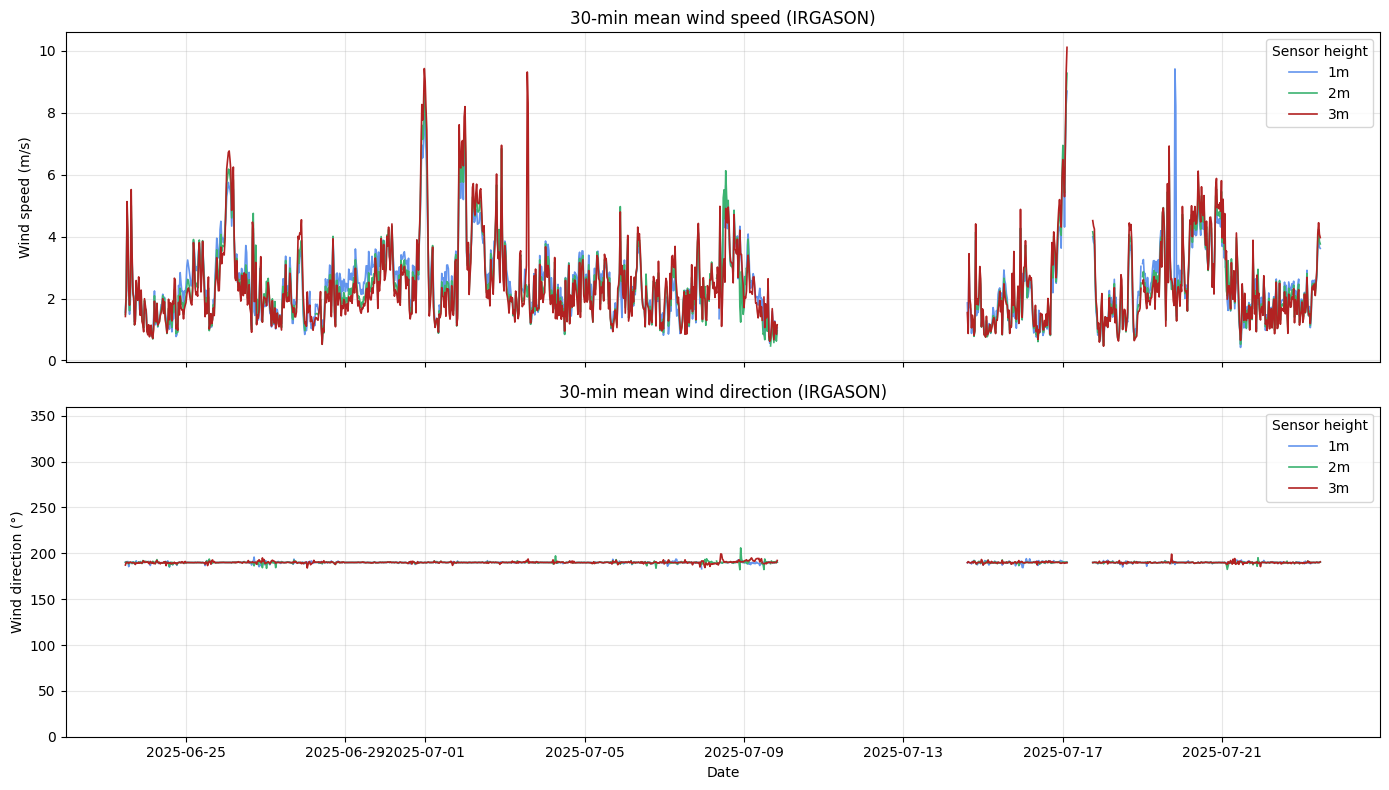

In [14]:
import matplotlib.pyplot as plt

COLORS = {
    "1m": "cornflowerblue",
    "2m": "mediumseagreen",
    "3m": "firebrick",
}

ordered_sensors = [sensor for sensor in ["1m", "2m", "3m"] if sensor in wind_series_30min]
if not ordered_sensors:
    raise ValueError("No resampled wind series available; run the preprocessing cell first.")

for sensor in ordered_sensors:
    info = sensor_series_info.get(sensor, {})
    print(
        f"Sensor {sensor}: timestamp={info.get('timestamp_label', 'n/a')}, "
        f"wind speed={info.get('ws_label', 'n/a')}, wind direction={info.get('wd_label', 'n/a')}"
    )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for sensor in ordered_sensors:
    resampled = wind_series_30min[sensor]
    color = COLORS.get(sensor, "gray")

    ax1.plot(resampled.index, resampled["wind_speed"], label=f"{sensor}", color=color, linewidth=1.2)
    ax2.plot(resampled.index, resampled["wind_direction"], label=f"{sensor}", color=color, linewidth=1.2)

ax1.set_ylabel("Wind speed (m/s)")
ax1.set_title("30-min mean wind speed (IRGASON)")
ax1.grid(True, alpha=0.3)
ax1.legend(title="Sensor height")

ax2.set_ylabel("Wind direction (°)")
ax2.set_xlabel("Date")
ax2.set_title("30-min mean wind direction (IRGASON)")
ax2.set_ylim(0, 360)
ax2.grid(True, alpha=0.3)
ax2.legend(title="Sensor height")

plt.tight_layout()


Wind direction is shown as nearly constant at 190° over the entire field campaign duration. That makes no sense as for Silvia 2 on Silvrettagletscher I would have expected around 90° for katabatic conditions. 190° matches the orientation of the sensor itself; I assume the double rotation with PEDDY prior to processing with EddyPro causes this mishap.

**To do: reprocess data with PEDDY (without double rotation) and EddyPro (with double rotation)**